# Project Name - Brain Tumour Classification

# Project Summary

Building Custom CNN models using VGG16 as base and adding 2 hyperparameters for tuning which are Sine Cose Optimizer and Grey wolf optimizer , then using a prebuilt model ( mobileNetV2 )

# Github Link

In [3]:
!pip install tensorflow keras opencv-python matplotlib seaborn pandas scikit-learn 

## Data augmentation

 splitting into training/validation automatically by folder structure, normalizing images, and augmenting training images.

In [6]:
import os

dataset_path = '/kaggle/input/braintumour/Tumour'
train_dir = '/kaggle/input/braintumour/Tumour/train'
val_dir   = '/kaggle/input/braintumour/Tumour/valid'
test_dir  = '/kaggle/input/braintumour/Tumour/test'
print("Folders:", os.listdir(dataset_path))

Folders: ['README.dataset.txt', 'valid', 'test', 'train']


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # helps to augment images and generate batches of image data for training/validation.

IMG_SIZE = 224
BATCH_SIZE = 32


# as per the instructions given , we had to augment the data to create synthetic data for the model.
datagen = ImageDataGenerator(
    rescale=1./255,     # Normalizes pixel values to [0,1]
    validation_split=0.2,    # 20 % of the data is saved for futher validation
    rotation_range=15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # labels are one hot encoded , works great for multiclass classification - " 3 types of tumours."
    subset='training'   # 80 % training data will be there
)

# doing the same data augmentation , but for the validation data ; that is 20 %
val_data = datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

NUM_CLASSES = train_data.num_classes
class_names = list(train_data.class_indices.keys())

# counting the number of classes (3) and how many images are present inside the folders
print(class_names)

2025-07-24 11:27:43.442065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753356463.736222      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753356463.818361      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 1358 images belonging to 4 classes.
Found 98 images belonging to 4 classes.
['glioma', 'meningioma', 'no_tumor', 'pituitary']


# Data analysis

In [54]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


In [55]:
train_dir = '/kaggle/input/braintumour/Tumour/train'

data = []

for label in os.listdir(train_dir):
    folder = os.path.join(train_dir, label)
    if not os.path.isdir(folder):  #  skip files like _classes.csv
        continue
    for img_file in os.listdir(folder):
        path = os.path.join(folder, img_file)
        try:
            img = Image.open(path).convert("L").resize((224, 224))
            img_arr = np.array(img) / 255.0
            data.append({
                'image_path': path,
                'tumor_type': label,
                'file_size': os.path.getsize(path) / 1024,  # in KB
                'pixel_mean': np.mean(img_arr),
                'pixel_std': np.std(img_arr),
                'width': img.width,
                'height': img.height
            })
        except Exception as e:
            print(f" Failed to process {path}: {e}")

df = pd.DataFrame(data)
df.head()



,image_path,tumor_type,file_size,pixel_mean,pixel_std,width,height
0,/kaggle/input/braintumour/Tumour/train/pituita...,pituitary,39.508789,0.186303,0.148413,224,224
1,/kaggle/input/braintumour/Tumour/train/pituita...,pituitary,34.549805,0.191620,0.163928,224,224
2,/kaggle/input/braintumour/Tumour/train/pituita...,pituitary,33.449219,0.229017,0.170089,224,224
3,/kaggle/input/braintumour/Tumour/train/pituita...,pituitary,38.927734,0.219872,0.179936,224,224
4,/kaggle/input/braintumour/Tumour/train/pituita...,pituitary,36.070312,0.184975,0.163370,224,224


# Univariate analysis

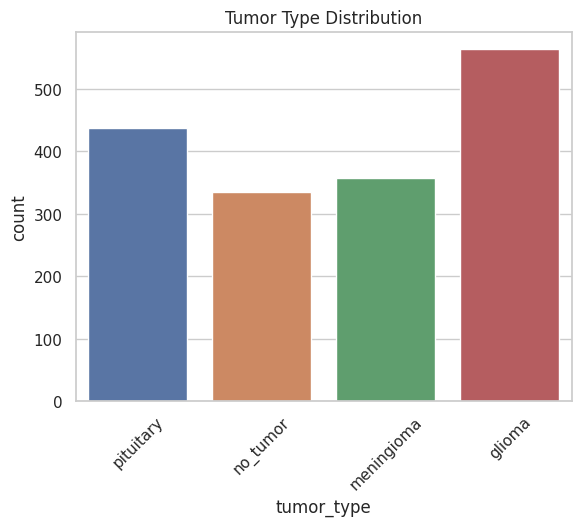

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


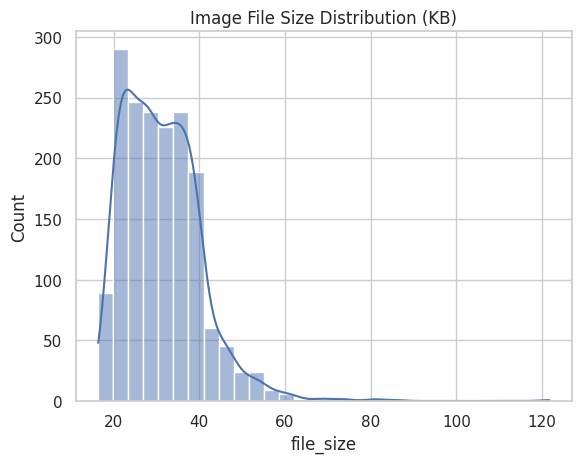

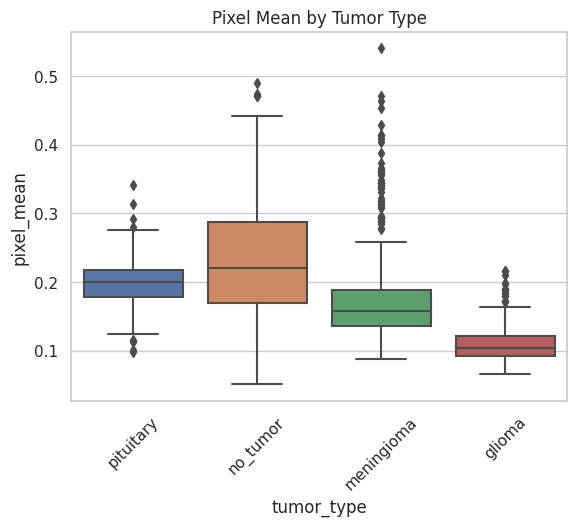

In [56]:
# Tumor class distribution
sns.countplot(x='tumor_type', data=df)
plt.title("Tumor Type Distribution")
plt.xticks(rotation=45)
plt.show()

# File size distribution
sns.histplot(df['file_size'], bins=30, kde=True)
plt.title("Image File Size Distribution (KB)")
plt.show()

# Mean pixel intensity per class
sns.boxplot(x='tumor_type', y='pixel_mean', data=df)
plt.title("Pixel Mean by Tumor Type")
plt.xticks(rotation=45)
plt.show()

***Tumor Type Distribution***

* The number of samples available for each class (glioma, meningioma, pituitary,no_tumor).

* If some classes (e.g., no_tumor) dominate.

* Model may bias toward that class.

* Leads to poor generalization for underrepresented tumors.

* If well balanced: model likely trains more fairly across classes.



***File Size Distribution***

* A wide spread may indicate inconsistent image quality, compression, or source differences.

* Smaller file sizes might mean loss of detail (aggressive compression).

* Larger sizes might represent high-resolution scans or higher contrast images.

* Action: Consider resizing and normalizing files to ensure consistency.


***Pixel Mean by Tumor Type***

* If one class consistently has higher or lower brightness:

* The model may learn to differentiate based on brightness, not tumor patterns.

* Could be caused by different scanners, not the biological difference.

## Bivariate analysis

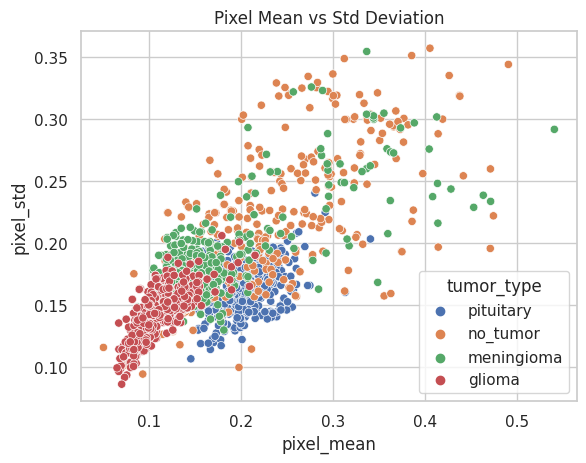

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


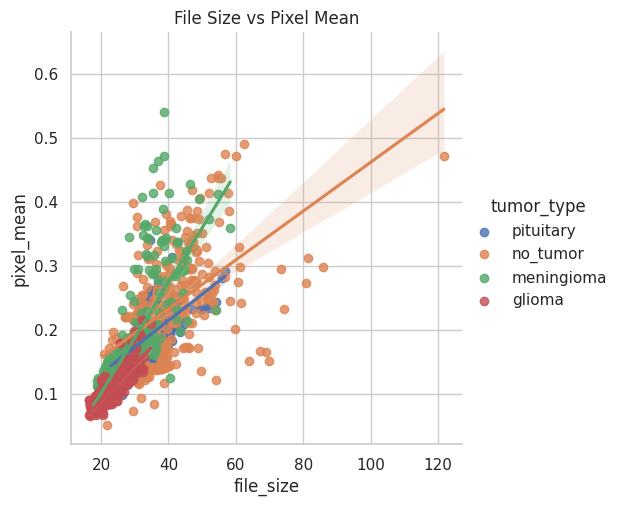

In [58]:
# Mean vs Std scatter
sns.scatterplot(x='pixel_mean', y='pixel_std', hue='tumor_type', data=df)
plt.title("Pixel Mean vs Std Deviation")
plt.show()

# File size vs pixel mean
sns.lmplot(x='file_size', y='pixel_mean', hue='tumor_type', data=df)
plt.title("File Size vs Pixel Mean")
plt.show()

***Pixel Mean vs Pixel Std***

* Tumor types form natural clusters? That’s good — shows intrinsic separability.

* Overlap between types? Suggests they share similar pixel distribution patterns.

* Outliers may be misclassified or corrupted images.

***File Size vs Pixel Mean***

* A positive correlation could mean brighter images are also bigger, possibly due to contrast or resolution differences.

* Consistent linear trends per tumor type may suggest each tumor class has distinct acquisition settings.

* If classes are clearly separable, the model could exploit this (might be good or misleading depending on cause).

## Multivariate analysis

***Pairplot***

* If tumor types cluster in certain dimensions, there is latent structure.

* If glioma overlaps strongly with meningioma, may explain misclassifications.

* Identify which features are more discriminative.

***Correlation Heatmap***

* Strong correlation between features (e.g., pixel_mean and pixel_std) → possible redundancy.

* Weak correlation between file_size and others → adds independent info, which is good for training.

* Helps select informative and non-redundant features for classical ML models (if used).

## Building custom model on top of existing VGG (Visual Geometry Group) 16 model

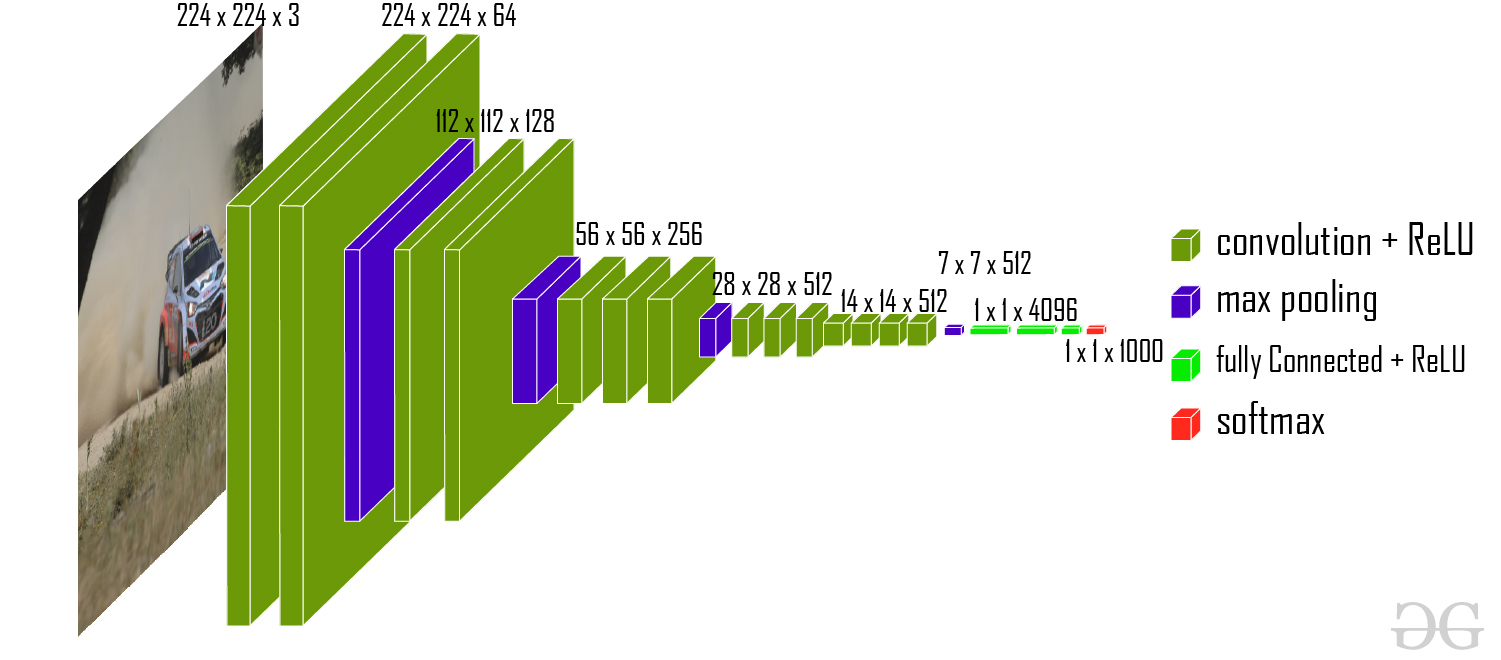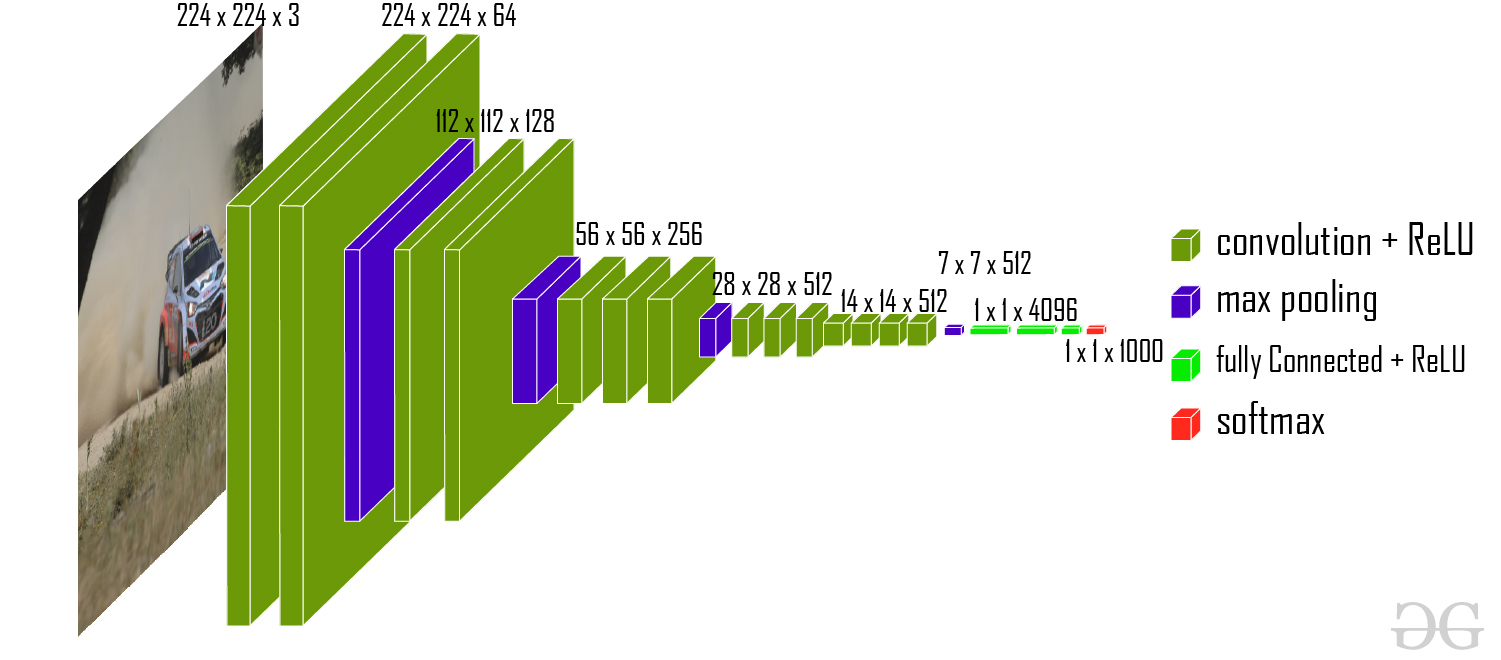

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D

# Load VGG16 from local weights file
base_model = VGG16(
    include_top=False,
    weights="/kaggle/input/vgg16-model-weights/keras/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",  # Update path as per upload
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,32

 Total params: 15,111,748 (57.65 MB)

 Trainable params: 396,036 (1.51 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

## Model Compilation using Adam optimizer


Adam optimizer uses Stochastic gradient descent with momentum and RMSPROP


1.   **SGD with momentum**

  Each epoch has one iteration ( uses one datapoint at a time ) , when using with momentum , the weight updation formulae changes in accordance to the time series . Helps in smoothening the curve of the GD using exponential weighted  average .

  **Formula for Exponential weighted average** :-

  *Vt1 = a1 , vt2 = (β) * Vt1 + (1-β) * a2*


2.   **RMSPROP**

  uses dynamic learning rate , as convergence happens we need to change the   learning rate in order to reach the minima effectively and easily .

  *λ' = λ / √(α + 	ε)*

  where **α** is the square of differential of loss wrt time , ε is a constant  such that the sum dont become zero .


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

'''Using adam optimizer and categorical_crossentropy loss which is best for multiclass classification problems . Also our plus point is that we are using OHE for labels .'''

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("baseline_model.h5", save_best_only=True)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=callbacks
)

'''
Trains the model using train_data and validates using val_data.

Trains up to 20 epochs, but may stop early if loss doesn’t improve (due to EarlyStopping).

The history object will store loss/accuracy values for plotting later.


'''


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 455s 10s/step - accuracy: 0.6188 - loss: 1.0124 - val_accuracy: 0.4490 - val_loss: 1.1817
Epoch 2/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 448s 10s/step - accuracy: 0.8038 - loss: 0.5318 - val_accuracy: 0.6224 - val_loss: 1.0557
Epoch 3/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 444s 10s/step - accuracy: 0.8258 - loss: 0.4927 - val_accuracy: 0.5510 - val_loss: 1.0271
Epoch 4/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 448s 10s/step - accuracy: 0.8479 - loss: 0.4158 - val_accuracy: 0.6224 - val_loss: 0.9309
Epoch 5/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 435s 10s/step - accuracy: 0.8385 - loss: 0.4539 - val_accuracy: 0.5816 - val_loss: 1.0108
Epoch 6/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 433s 10s/step - accuracy: 0.8554 - loss: 0.3723 - val_accuracy: 0.6224 - val_loss: 0.8630
Epoch 7/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 439s 10s/step - accuracy: 0.8457 - loss: 0.4175 - val_accuracy: 0.5816 - val_loss: 0.8391
Epoch 8/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 457s 11s/step - accuracy: 0.8578 - loss: 0.3613 - val_accuracy: 0.

'\nTrains the model using train_data and validates using val_data.\n\nTrains up to 20 epochs, but may stop early if loss doesn’t improve (due to EarlyStopping).\n\nThe history object will store loss/accuracy values for plotting later.\n\n\n'

Callbacks used are EarlyStopping and ModelCheckpoint



1.   **Earlystopping**

It is used to monitor the validation score / loss on each step , Patience = 5: Stops training if val_loss doesn’t improve for 5 consecutive epochs. Restores the weights from the epoch with the best val_loss, not the last one.

2.   **ModelCheckpoint**

Saves the model to "baseline_model.h5" only when it improves (i.e., best loss so far) . Ensures that we have the best version saved, even if later epochs perform worse.


# Sine cosine Optimization and Grey Wolf Optimizer


1. *The Sin Cosine Optimizer (SCO) is a metaheuristic global optimizer that
adjusts parameters using a combination of sine and cosine functions, making it suitable for optimizing neural network weights without gradient backpropagation.*

2. *GWO is a metaheuristic algorithm that mimics the leadership hierarchy of grey wolves:*

  * *Alpha (best solution)*

  * *Beta, Delta (2nd and 3rd best)*

  * *Omega (rest of the population)*

*It updates the position of wolves (solutions) based on Alpha, Beta, Delta to explore the best regions of the search space.*


In [18]:
import numpy as np

class SCO:
    def __init__(self, obj_func, dim, bounds, pop_size=10, max_iter=20):
        self.obj_func = obj_func
        self.dim = dim
        self.bounds = bounds
        self.pop_size = pop_size
        self.max_iter = max_iter

        self.population = np.random.uniform(bounds[0], bounds[1], (pop_size, dim))
        self.fitness = np.array([self.obj_func(ind) for ind in self.population])
        self.best_idx = np.argmin(self.fitness)
        self.best = self.population[self.best_idx].copy()

    def optimize(self):


        for t in range(self.max_iter):
            r1 = np.sin((1 - t / self.max_iter) * np.pi / 2)
            r2 = np.random.rand(self.pop_size, self.dim)
            r3 = np.random.rand(self.pop_size, self.dim)
            r4 = np.random.rand(self.pop_size, self.dim)

            new_pop = np.where(r4 < 0.5,
                               self.population + r1 * np.sin(r2) * np.abs(r3 * self.best - self.population),
                               self.population + r1 * np.cos(r2) * np.abs(r3 * self.best - self.population))

            # Clip to bounds
            new_pop = np.clip(new_pop, self.bounds[0], self.bounds[1])
            new_fit = np.array([self.obj_func(ind) for ind in new_pop])

            for i in range(self.pop_size):
                if new_fit[i] < self.fitness[i]:
                    self.fitness[i] = new_fit[i]
                    self.population[i] = new_pop[i].copy()
                    if new_fit[i] < self.fitness[self.best_idx]:
                        self.best_idx = i
                        self.best = new_pop[i].copy()

        return self.best, self.fitness[self.best_idx]

'''
 Sine Cosine Optimizer (SCO) Implementation

 This class implements the Sine Cosine Optimization algorithm for continuous optimization problems.
 It iteratively updates a population of candidate solutions using sine and cosine-based position updates
 to explore and exploit the search space. The goal is to minimize a user-defined objective function.
 For each iteration compute r1, a decreasing sine function over time to gradually reduce exploration
 useing random numbers r2,r3,r4 for movement stratergy , applies sin or cos of random direction
 to move toward the best solution
'''


'\n Sine Cosine Optimizer (SCO) Implementation\n\n This class implements the Sine Cosine Optimization algorithm for continuous optimization problems.\n It iteratively updates a population of candidate solutions using sine and cosine-based position updates\n to explore and exploit the search space. The goal is to minimize a user-defined objective function.\n For each iteration compute r1, a decreasing sine function over time to gradually reduce exploration\n useing random numbers r2,r3,r4 for movement stratergy , applies sin or cos of random direction\n to move toward the best solution\n'

In [19]:
from tensorflow.keras.models import clone_model

def sco_objective_function(flat_weights):

    # Clone base model and set weights
    temp_model = clone_model(model)
    temp_model.set_weights(original_weights)  # Start from pre-trained base

    # Inject SCO-optimized weights into the classifier head
    custom_layers = temp_model.layers[-3:]  # Dense(512), Dense(256), Dense(NUM_CLASSES)
    idx = 0
    new_weights = []

    for layer in custom_layers:
        if hasattr(layer, 'get_weights'):
            shapes = [w.shape for w in layer.get_weights()]
            weights = []
            for shape in shapes:
                size = np.prod(shape)
                weights.append(flat_weights[idx:idx+size].reshape(shape))
                idx += size
            new_weights.append(weights)

    # Apply new weights
    i = 0
    for layer in custom_layers:
        if hasattr(layer, 'get_weights'):
            layer.set_weights(new_weights[i])
            i += 1

    temp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    loss, acc = temp_model.evaluate(val_data, verbose=0)
    return loss  # Minimize loss

# Objective function for Sine Cosine Optimization (SCO)
'''
 This function evaluates a flattened vector of weights proposed by SCO by:
 1. Cloning the base Keras model structure and resetting it to the original pre-trained weights.
 2. Replacing the weights of the last three dense layers (the classifier head) with the provided flattened values.
 3. Compiling and evaluating the modified model on validation data.

 The function returns the validation loss as the objective to be minimized by SCO.

 Parameters:
 - flat_weights (np.ndarray): A 1D array representing all weights of the last three dense layers.

 Returns:
 - float: The validation loss computed using the modified model.
'''


'\n This function evaluates a flattened vector of weights proposed by SCO by:\n 1. Cloning the base Keras model structure and resetting it to the original pre-trained weights.\n 2. Replacing the weights of the last three dense layers (the classifier head) with the provided flattened values.\n 3. Compiling and evaluating the modified model on validation data.\n\n The function returns the validation loss as the objective to be minimized by SCO.\n\n Parameters:\n - flat_weights (np.ndarray): A 1D array representing all weights of the last three dense layers.\n\n Returns:\n - float: The validation loss computed using the modified model.\n'

In [20]:
# Get initial classifier weights
original_weights = model.get_weights()

# Flatten weights of classifier only
flat_classifier_weights = []
classifier_layers = model.layers[-3:]  # Last 3 dense layers
for layer in classifier_layers:
    for w in layer.get_weights():
        flat_classifier_weights.extend(w.flatten())

flat_classifier_weights = np.array(flat_classifier_weights)

# Set bounds
dim = flat_classifier_weights.shape[0]
bounds = (-1.0, 1.0)  # Reasonable initial range

# Run SCO
sco = SCO(obj_func=sco_objective_function, dim=dim, bounds=bounds, pop_size=10, max_iter=10)
best_weights, best_loss = sco.optimize()
print("Best Validation Loss after SCO:", best_loss)


Best Validation Loss after SCO: 19.206796646118164


In [21]:
idx = 0
for layer in model.layers[-3:]:
    if hasattr(layer, 'get_weights'):
        shapes = [w.shape for w in layer.get_weights()]
        new_weights = []
        for shape in shapes:
            size = np.prod(shape)
            new_weights.append(best_weights[idx:idx+size].reshape(shape))
            idx += size
        layer.set_weights(new_weights)

print(" Injected manual SCO weights into model.")


 Injected manual SCO weights into model.


In [22]:
model.save("vgg16_bcm_sco_manual_optimized.h5")


# GWO - Grey Wolf Optimization

In [24]:
'''
Grey Wolf Optimizer (GWO) Implementation

 This class implements the Grey Wolf Optimization algorithm for minimizing a given objective function.
 GWO mimics the leadership hierarchy and hunting strategy of grey wolves in nature.
 It maintains three leading wolves: alpha (best), beta (second-best), and delta (third-best),
 which guide the position updates of the rest of the population (omega wolves).

 Key Steps:
 - Initialize random population within given bounds
 - Evaluate fitness and select alpha, beta, delta
 - Update positions based on a, A, C coefficients and the leader wolves
 - Iteratively refine the population for a set number of iterations

 Parameters:
 - obj_func: Objective function to minimize
 - dim: Number of dimensions (parameters to optimize)
 - bounds: Tuple (lower_bound, upper_bound) for each dimension
 - pop_size: Number of wolves in the population
 - max_iter: Number of iterations to run

 Returns:
 - Best solution found (position of the alpha wolf)
 - Corresponding best fitness (objective value)

'''

import numpy as np


class GWO:
    def __init__(self, obj_func, dim, bounds, pop_size=10, max_iter=20):
        self.obj_func = obj_func
        self.dim = dim
        self.bounds = bounds
        self.pop_size = pop_size
        self.max_iter = max_iter

        self.population = np.random.uniform(bounds[0], bounds[1], (pop_size, dim))
        self.fitness = np.array([self.obj_func(ind) for ind in self.population])

        self.alpha, self.beta, self.delta = self.select_leaders()

    def select_leaders(self):
        sorted_indices = np.argsort(self.fitness)
        return (self.population[sorted_indices[0]],
                self.population[sorted_indices[1]],
                self.population[sorted_indices[2]])

    def optimize(self):
        for t in range(self.max_iter):
            a = 2 - t * (2 / self.max_iter)

            for i in range(self.pop_size):
                A1 = 2 * a * np.random.rand(self.dim) - a
                C1 = 2 * np.random.rand(self.dim)
                D_alpha = np.abs(C1 * self.alpha - self.population[i])
                X1 = self.alpha - A1 * D_alpha

                A2 = 2 * a * np.random.rand(self.dim) - a
                C2 = 2 * np.random.rand(self.dim)
                D_beta = np.abs(C2 * self.beta - self.population[i])
                X2 = self.beta - A2 * D_beta

                A3 = 2 * a * np.random.rand(self.dim) - a
                C3 = 2 * np.random.rand(self.dim)
                D_delta = np.abs(C3 * self.delta - self.population[i])
                X3 = self.delta - A3 * D_delta

                self.population[i] = (X1 + X2 + X3) / 3.0

            self.population = np.clip(self.population, self.bounds[0], self.bounds[1])
            self.fitness = np.array([self.obj_func(ind) for ind in self.population])
            self.alpha, self.beta, self.delta = self.select_leaders()

        best_idx = np.argmin(self.fitness)
        return self.population[best_idx], self.fitness[best_idx]


In [25]:
'''
 Objective function for Grey Wolf Optimizer (GWO)

 This function evaluates a candidate solution (a flat vector of weights) by:
 1. Cloning the original Keras model structure.
 2. Resetting it to the base pre-trained weights (`original_weights`).
 3. Replacing the weights of the final 3 dense layers (i.e., classifier head) with values from `flat_weights`.
 4. Compiling the modified model and evaluating its performance on validation data.

 The function returns the validation loss, which the GWO algorithm will attempt to minimize.

 Parameters:
 - flat_weights (np.ndarray): Flattened weights vector representing the last 3 layers.

 Returns:
 - float: Validation loss of the modified model.
'''


from tensorflow.keras.models import clone_model

def gwo_objective_function(flat_weights):
    temp_model = clone_model(model)
    temp_model.set_weights(original_weights)

    idx = 0
    for layer in temp_model.layers[-3:]:
        if hasattr(layer, 'get_weights'):
            shapes = [w.shape for w in layer.get_weights()]
            new_weights = []
            for shape in shapes:
                size = np.prod(shape)
                new_weights.append(flat_weights[idx:idx+size].reshape(shape))
                idx += size
            layer.set_weights(new_weights)

    temp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    loss, _ = temp_model.evaluate(val_data, verbose=0)
    return loss


In [26]:
# Adding / updating the weights as per GWO
original_weights = model.get_weights()

flat_classifier_weights = []
for layer in model.layers[-3:]:
    for w in layer.get_weights():
        flat_classifier_weights.extend(w.flatten())

flat_classifier_weights = np.array(flat_classifier_weights)
dim = flat_classifier_weights.shape[0]
bounds = (-1.0, 1.0)


In [27]:
gwo = GWO(obj_func=gwo_objective_function, dim=dim, bounds=bounds, pop_size=10, max_iter=10)
gwo_best_weights, gwo_best_loss = gwo.optimize()

print(" GWO Optimization Done")
print(" Best Validation Loss:", gwo_best_loss)


 GWO Optimization Done
 Best Validation Loss: 10.629020690917969


In [28]:
idx = 0
for layer in model.layers[-3:]:
    if hasattr(layer, 'get_weights'):
        shapes = [w.shape for w in layer.get_weights()]
        new_weights = []
        for shape in shapes:
            size = np.prod(shape)
            new_weights.append(gwo_best_weights[idx:idx+size].reshape(shape))
            idx += size
        layer.set_weights(new_weights)

print(" Injected GWO-optimized weights into model.")


 Injected GWO-optimized weights into model.


In [29]:
model.save("vgg16_bcm_gwo_manual_optimized.h5")
print("Saved: vgg16_bcm_gwo_manual_optimized.h5")


Saved: vgg16_bcm_gwo_manual_optimized.h5


# Evaluation

In [38]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [39]:
def evaluate_model(model_path, name, val_data):
    print(f" Evaluating: {name}")

    model = load_model(model_path)
    preds = model.predict(val_data)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_data.classes

    # Accuracy
    acc = np.mean(y_true == y_pred) * 100
    print(f" Accuracy: {acc:.2f}%")

    # Classification report
    print(" Classification Report:")
    print(classification_report(y_true, y_pred, target_names=val_data.class_indices.keys()))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=val_data.class_indices.keys(),
                yticklabels=val_data.class_indices.keys())
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


SyntaxError: invalid syntax (1763773627.py, line 1)

 Evaluating: VGG16 + BCM (SCO Manual)
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step
 Accuracy: 24.49%
 Classification Report:
              precision    recall  f1-score   support

      glioma       0.33      0.31      0.32        32
  meningioma       0.12      0.08      0.10        24
    no_tumor       0.22      0.58      0.32        19
   pituitary       1.00      0.04      0.08        23

    accuracy                           0.24        98
   macro avg       0.42      0.25      0.21        98
weighted avg       0.42      0.24      0.21        98



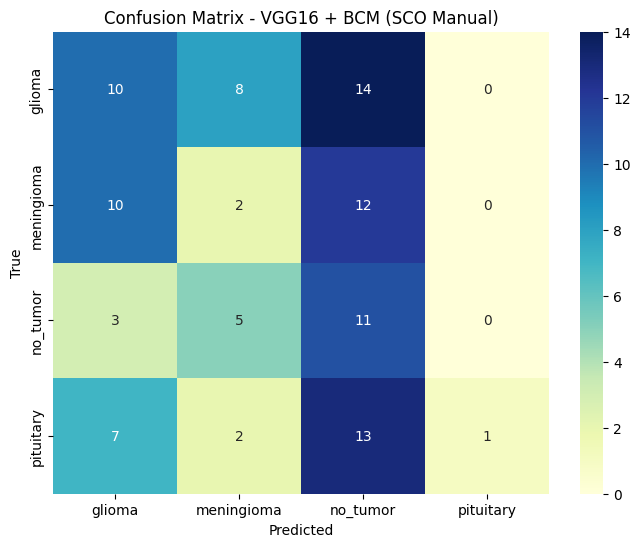

 Evaluating: VGG16 + BCM (GWO Manual)
4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 7s/step
 Accuracy: 23.47%
 Classification Report:
              precision    recall  f1-score   support

      glioma       0.34      0.47      0.39        32
  meningioma       0.24      0.29      0.26        24
    no_tumor       0.06      0.05      0.06        19
   pituitary       0.00      0.00      0.00        23

    accuracy                           0.23        98
   macro avg       0.16      0.20      0.18        98
weighted avg       0.18      0.23      0.20        98



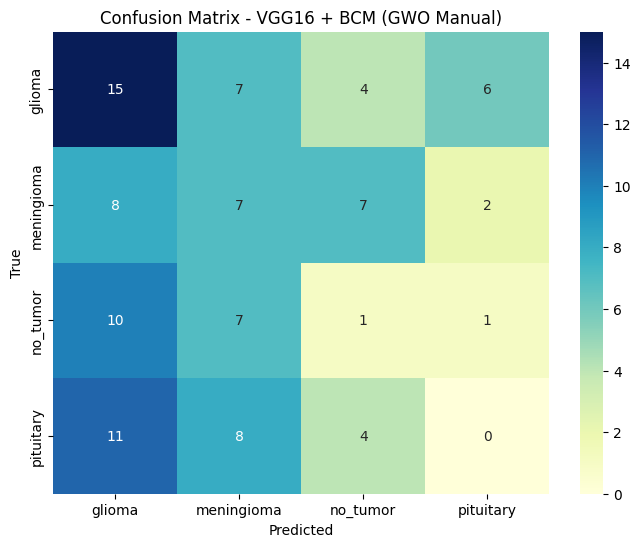

In [40]:
# evaluate_model("vgg16_bcm_adam.h5", "VGG16 + BCM (Adam)", val_data)
evaluate_model("vgg16_bcm_sco_manual_optimized.h5", "VGG16 + BCM (SCO Manual)", val_data)
evaluate_model("vgg16_bcm_gwo_manual_optimized.h5", "VGG16 + BCM (GWO Manual)", val_data)


# Pretrained model

In [43]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(
    include_top=False,
    weights="/kaggle/input/pretrained-model/keras/default/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5",
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze the base


In [44]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

pretrained_model = Model(inputs=base_model.input, outputs=predictions)
pretrained_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
pretrained_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("mobilenetv2_pretrained_model.h5", save_best_only=True)
]

history_pretrained = pretrained_model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.5885 - loss: 1.0987 - val_accuracy: 0.7857 - val_loss: 0.6373
Epoch 2/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7995 - loss: 0.5075 - val_accuracy: 0.7551 - val_loss: 0.6120
Epoch 3/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8742 - loss: 0.3704 - val_accuracy: 0.6837 - val_loss: 0.7742
Epoch 4/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8736 - loss: 0.3440 - val_accuracy: 0.7857 - val_loss: 0.5540
Epoch 5/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8845 - loss: 0.3151 - val_accuracy: 0.7449 - val_loss: 0.6230
Epoch 6/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8955 - loss: 0.2909 - val_accuracy: 0.7245 - val_loss: 0.6379
Epoch 7/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8997 - loss: 0.2636 - val_accuracy: 0.7551 - val_loss: 0.6206
Epoch 8/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9148 - loss: 0.2441 - val_accuracy: 0.7959 - val_loss:

In [ ]:
evaluate_model("mobilenetv2_pretrained_model.h5", "MobileNetV2 (Transfer Learning)", val_data)


# Testing

testing all the models on the test images to see if the models predict efficiently or not

In [47]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
import os

In [48]:
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

In [49]:
from tensorflow.keras.models import load_model

models = {
    "VGG16 + BCM (Adam)": load_model("baseline_model.h5"),
    "VGG16 + BCM (SCO)": load_model("vgg16_bcm_sco_manual_optimized.h5"),
    "VGG16 + BCM (GWO)": load_model("vgg16_bcm_gwo_manual_optimized.h5"),
    "MobileNetV2": load_model("mobilenetv2_pretrained_model.h5")
}


In [50]:
from PIL import Image
import numpy as np

def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0)


In [51]:
def predict_with_all_models(img_path):
    img_array = preprocess_image(img_path)

    print(f"\n Uploaded Image: {os.path.basename(img_path)}\n")
    for name, model in models.items():
        preds = model.predict(img_array)
        pred_class_idx = np.argmax(preds)
        pred_class = class_names[pred_class_idx]
        confidence = np.max(preds)

        print(f" {name}")
        print(f" Predicted: {pred_class}")
        print(f" Confidence: {confidence * 100:.2f}%\n")


In [53]:
predict_with_all_models("/kaggle/input/braintumour/Tumour/test/meningioma/Tr-me_0069_jpg.rf.332331a0dda2f9e803c7bff6ad5ae3eb.jpg")



 Uploaded Image: Tr-me_0069_jpg.rf.332331a0dda2f9e803c7bff6ad5ae3eb.jpg

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
 VGG16 + BCM (Adam)
 Predicted: glioma
 Confidence: 56.64%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
 VGG16 + BCM (SCO)
 Predicted: meningioma
 Confidence: 100.00%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
 VGG16 + BCM (GWO)
 Predicted: meningioma
 Confidence: 90.66%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
 MobileNetV2
 Predicted: meningioma
 Confidence: 89.56%

